# Visualización de datos

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly_express as px

from sklearn.cluster import KMeans

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import socket
import struct

In [23]:
mainpath="../Sample dataset/"
filename="dataset1.csv"
filename2="dataset2.csv"

In [24]:
df1 = pd.read_csv(mainpath + filename)
df2 = pd.read_csv(mainpath + filename2)
df3 = df1.append(df2)

In [25]:
df1.head()

,__time,level,application_id,application_name,direction,engine_id,host,host_category,wan_ip_country_code,lan_ip_country_code,...,wan_ip_as_name,wan_l4_port,serial_number,saas_name,saas_family,host_l2,referer_l2,events,sum_bytes,sum_pkts
0,1639399860000,23f24570-d2c9-4e6e-a833-3d1734e110c8.abcc9097-...,6:3,PRIVATE ADDRESSING,upstream,6,teams.events.data.microsoft.com,cleaning,US,CN,...,ATT-INTERNET4,771,848/06464,NaN,NaN,microsoft.com,NaN,1,229,1
1,1639399860000,23f24570-d2c9-4e6e-a833-3d1734e110c8.abcc9097-...,6:3,PRIVATE ADDRESSING,upstream,6,ssl.gstatic.com,liste_blanche,US,US,...,AKAMAI-AS,54606,848/06464,Google portal and shared services,IT & Communication,gstatic.com,NaN,1,509,1
2,1639399860000,23f24570-d2c9-4e6e-a833-3d1734e110c8.abcc9097-...,6:3,PRIVATE ADDRESSING,upstream,6,r2.sn-h5qzen76.googlevideo.com,movies,US,US,...,EDGECAST,60733,848/06464,Youtube,Streaming,googlevideo.com,NaN,1,524,1
3,1639399860000,23f24570-d2c9-4e6e-a833-3d1734e110c8.abcc9097-...,6:3,PRIVATE ADDRESSING,upstream,6,presence.teams.microsoft.com,cleaning,US,US,...,ATGS-MMD-AS,58244,848/06464,NaN,NaN,microsoft.com,NaN,1,540,1
4,1639399860000,23f24570-d2c9-4e6e-a833-3d1734e110c8.abcc9097-...,6:3,PRIVATE ADDRESSING,upstream,6,play.google.com,shopping,US,CN,...,GOOGLE,65504,848/06464,Google Play,Storage,google.com,NaN,1,509,1


In [26]:
corr1=df1.corr()

<AxesSubplot:>

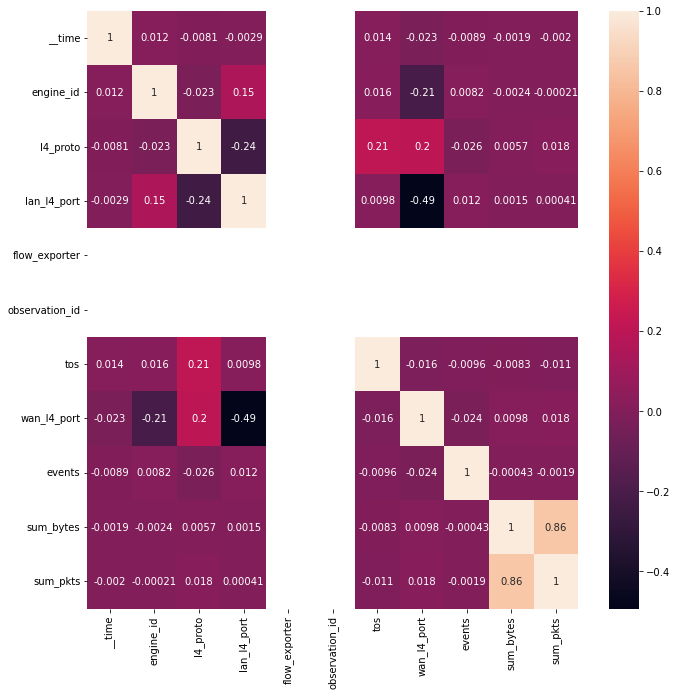

In [27]:
%matplotlib inline
import seaborn as sns
plt.figure(figsize=(11, 11))
sns.heatmap(corr1, annot = True)

* Las correlaciones más altas serían:

    sum_bytes -- sum_pkts
    
    lan_i4_port -- engine_id
    
    tos -- i4_proto
    
    wan_i4_port -- i4_proto
    


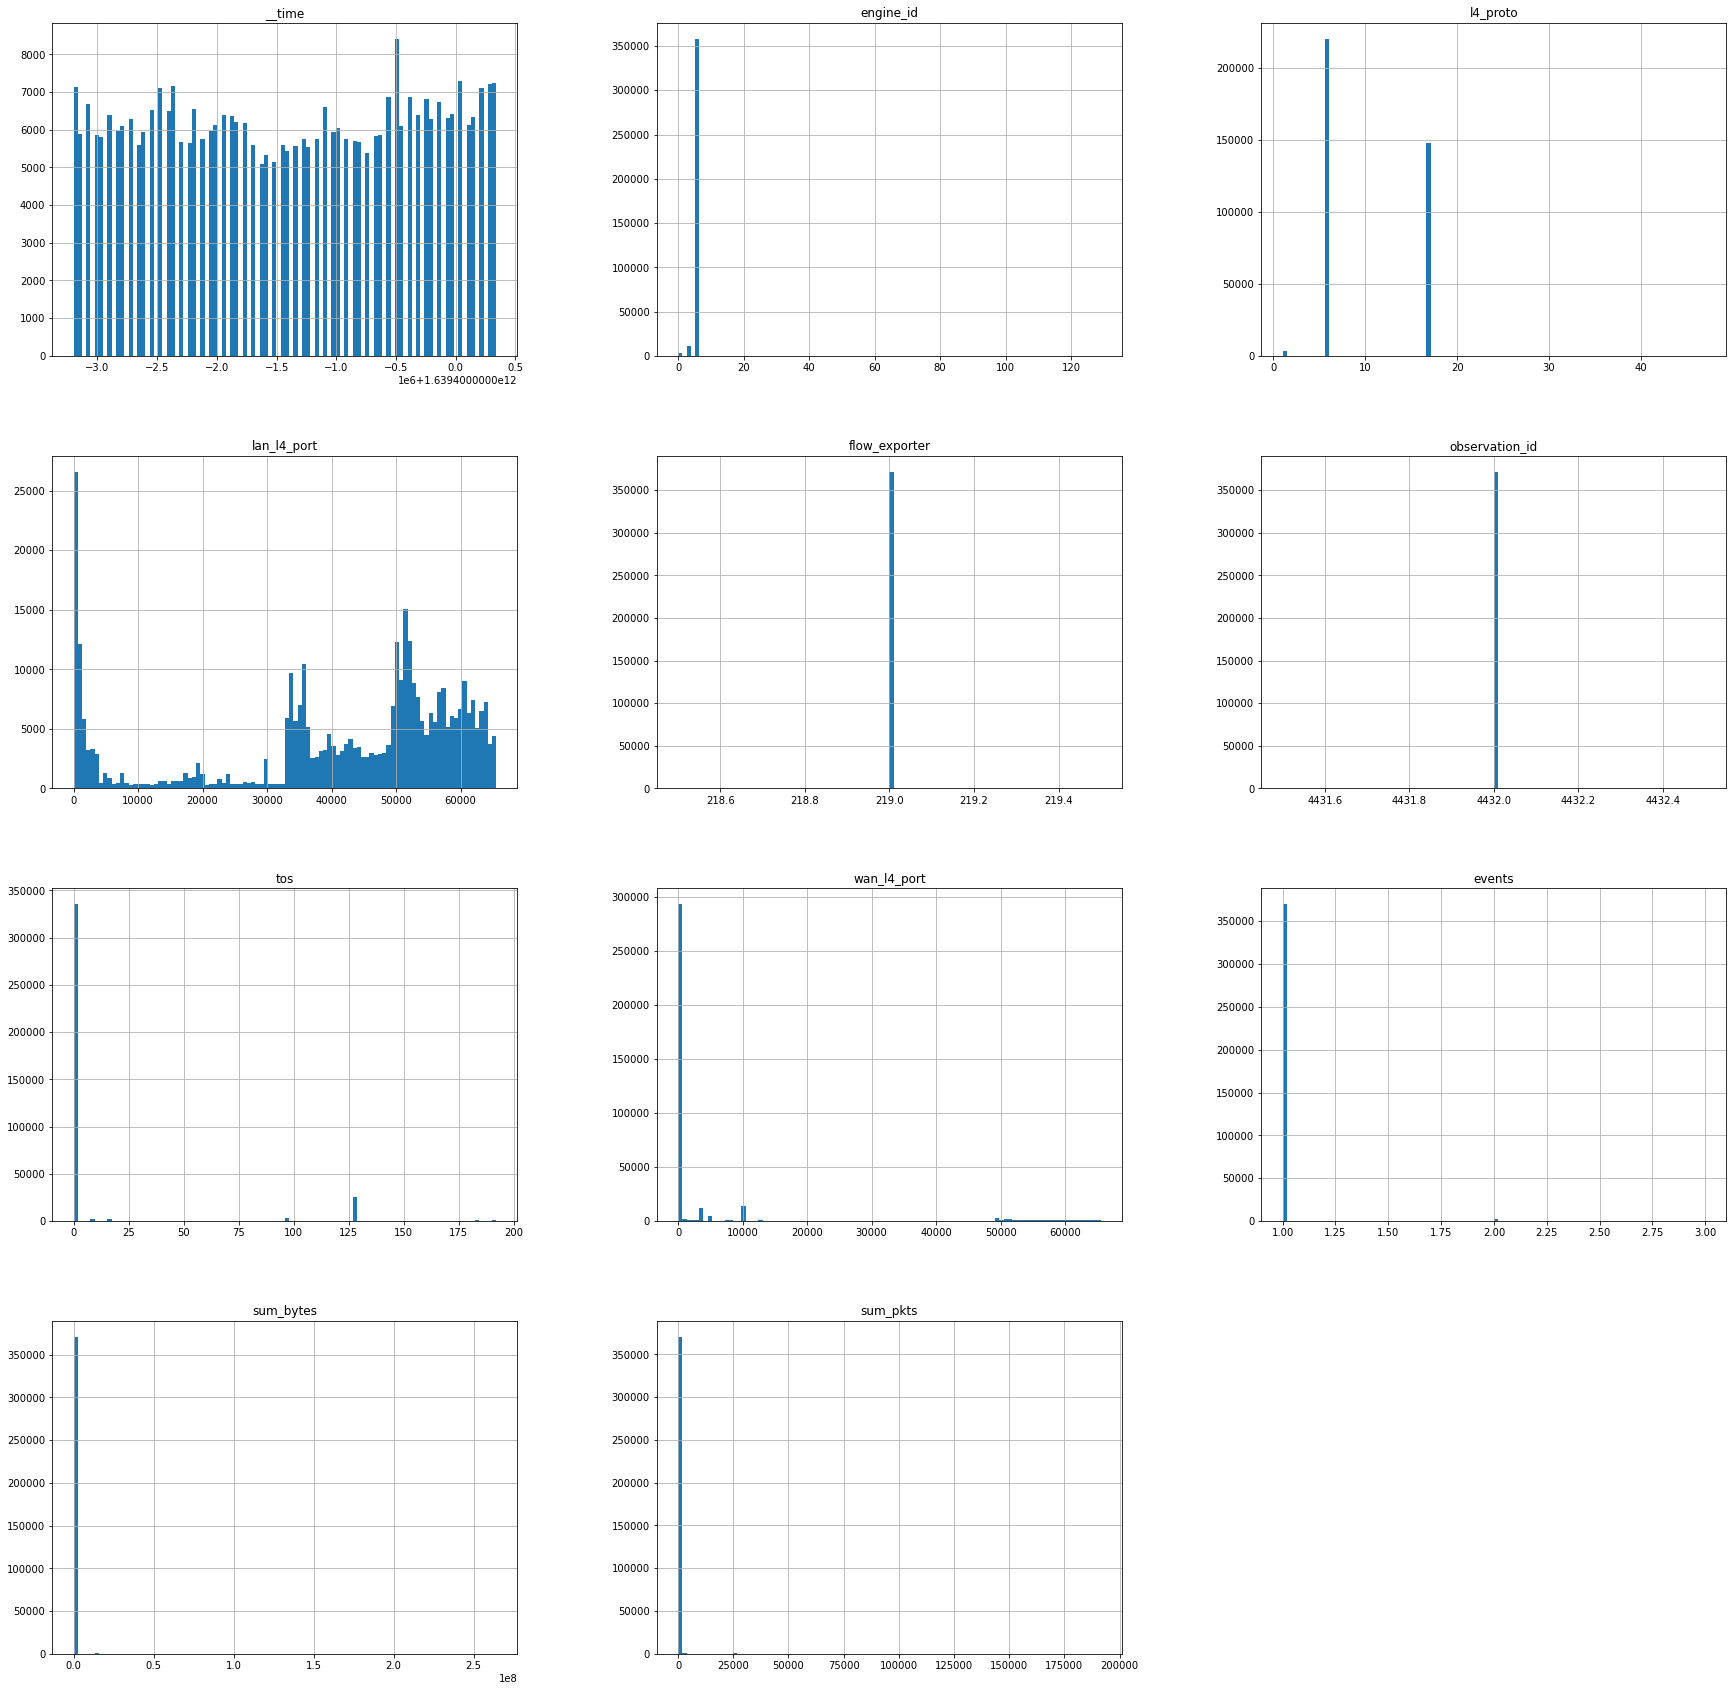

In [28]:
df1.hist(bins = 100, figsize=(30, 30))
plt.show()

*Comentarios de cada gráfica:*

    __time: Algunos segundos tiene más registros pero es bastante regular el número de registros por segundo
    
    engine_id: casi todos los valores son 6. Los valores son 0,3,6 y 129
    
    l4_proto: Los registros se reparten entre 6 y 17. Y unos pocos casos de 1
    
    lan_i4_port: Del puerto 0 al 1024 se usan para servicios privilegiados. El resto se puede usar libremente y 
    llega hasta el 65536 
    
    flow_exporter: siempre tiene el mismo valor 219. En principio sería descartable este campo
    
    observation_id: siempre tiene el mismo valor 4432. En principio sería descartable este campo
    
    tos: el valor que sale más veces es el 0. Luego hay 10 valores más con muchos menos registros
    
    wan_l4_port: Del puerto 0 al 1024 se usan para servicios privilegiados. El resto se puede usar libremente y 
    llega hasta el 65536. El uso de puertos está muy repartido excepto con el 443 que está muy utilizado ya que es para el trafico HTTPS
    
    events: el 1 es el mayoritario. Y soló hay el 1, 2 y 3
    
    
    
    
    
    
    


In [29]:
total_rows = len(df1.index)
print(len(df1.index))
print(len(df2.index))

371867
345503


In [30]:
print(len(df1["application_id"].unique()))
print(len(df1["application_name"].unique()))
print(df1["application_name"].unique())
print(df1["application_id"].unique())

29
29
['PRIVATE ADDRESSING' 'DEFAULT' '3:80' '3:53' '3:443' '3:179' '1:1' '0:0'
 '3:60000' '3:22' '3:123' 'MARCA' 'BINTEC' '3:514' '3:445' '3:137'
 '3:5432' '3:1433' '3:161' '129:1047' '3:15000' '129:1116' '129:34'
 '3:19903' '3:7996' '3:19902' 'CNM Internal Services' '3:19092' '3:52490']
['6:3' '6:2' '3:80' '3:53' '3:443' '3:179' '1:1' '0:0' '3:60000' '3:22'
 '3:123' '6:1' '6:0' '3:514' '3:445' '3:137' '3:5432' '3:1433' '3:161'
 '129:1047' '3:15000' '129:1116' '129:34' '3:19903' '3:7996' '3:19902'
 '6:7' '3:19092' '3:52490']


In [31]:
def ip2number(addr):
    return str(struct.unpack("!I", socket.inet_aton(addr))[0])


def int2ip(addr):
    return socket.inet_ntoa(struct.pack("!I", addr))

def add_metadata_columns(df_tmp):
    df = df_tmp.copy()
    
    df["__time"]=(pd.to_datetime(df["__time"],unit='ms')) 
    df['hour'] = df.__time.dt.hour
    
    df = df.join(df.groupby(['hour'])['sum_bytes'].mean(), on='hour', rsuffix='_hourly_mean')
    df = df.join(df.groupby(['hour'])['sum_bytes'].max(), on='hour', rsuffix='_hourly_min')
    df = df.join(df.groupby(['hour'])['sum_bytes'].min(), on='hour', rsuffix='_hourly_max')
    df = df.join(df.groupby(['hour'])['sum_bytes'].std(), on='hour', rsuffix='_hourly_std')
    
    df.drop("sum_bytes", axis=1, inplace=True)
    df.drop("__time", axis=1, inplace=True)
    df.drop("sum_pkts", axis=1, inplace=True)
    return df

def build_df(df_tmp, drop_lan_features=False):
    df = df_tmp.copy()
    
    if drop_lan_features:
        df.drop("lan_ip_country_code", axis=1, inplace=True)
        df.drop("lan_interface_name", axis=1, inplace=True)
        df.drop("lan_ip", axis=1, inplace=True)
        df.drop("lan_ip_as_name", axis=1, inplace=True)
        df.drop("lan_l4_port", axis=1, inplace=True)
        
    df['wan_ip'] = df['wan_ip'].map(ip2number)
    # Vamos a hacer drop de la columna "application_id" porque representa lo mismo que "application_name"
    df.drop("application_id", axis=1, inplace=True)
    total_rows = len(df.index)
    
    for column in df.columns:
        null_sum = df[column].isnull().sum()
        if null_sum != 0:
            null_percentage = null_sum / total_rows  * 100
            if null_percentage >= 50:
                #print(f'Deleted column: {column} ({null_percentage}%)')
                df.drop(column, axis=1, inplace=True)
    for column in df.columns:
        if len(df[column].unique()) == 1:
            df.drop(column, axis=1, inplace=True)
            #print(f'Deleted column because of unique value: {column}')
    
    for column in df.columns:
        if df[column].dtypes == "object":
            df[[column]] = df[[column]].apply(lambda col:pd.Categorical(col).codes)
        
    print(df.columns)
    print(len(df.columns))
        
    return df

def plot_3d(X, C, labels):
    colors=['red','green']#,'blue','cyan','yellow']
    assign=[]
    for row in labels:
        assign.append(colors[row])
 
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=assign,s=60)
    ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colors, s=1000)

In [32]:
df_no_lan = build_df(df1, drop_lan_features=True)
df_no_lan2 = build_df(df2, drop_lan_features=True)
df_no_lan3 = build_df(df3, drop_lan_features=True)

Index(['__time', 'application_name', 'direction', 'engine_id',
       'wan_ip_country_code', 'l4_proto', 'selector_name', 'tcp_flags', 'tos',
       'wan_interface_name', 'wan_ip', 'wan_ip_as_name', 'wan_l4_port',
       'events', 'sum_bytes', 'sum_pkts'],
      dtype='object')
16
Index(['__time', 'application_name', 'direction', 'engine_id',
       'wan_ip_country_code', 'l4_proto', 'selector_name', 'tcp_flags', 'tos',
       'wan_interface_name', 'wan_ip', 'wan_ip_as_name', 'wan_l4_port',
       'events', 'sum_bytes', 'sum_pkts'],
      dtype='object')
16
Index(['__time', 'application_name', 'direction', 'engine_id',
       'wan_ip_country_code', 'l4_proto', 'selector_name', 'tcp_flags', 'tos',
       'wan_interface_name', 'wan_ip', 'wan_ip_as_name', 'wan_l4_port',
       'events', 'sum_bytes', 'sum_pkts'],
      dtype='object')
16


In [33]:
df_no_lan.head()

,__time,application_name,direction,engine_id,wan_ip_country_code,l4_proto,selector_name,tcp_flags,tos,wan_interface_name,wan_ip,wan_ip_as_name,wan_l4_port,events,sum_bytes,sum_pkts
0,1639399860000,28,1,6,56,1,4,0,192,1,933,34,771,1,229,1
1,1639399860000,28,1,6,56,17,4,0,0,1,947,7,54606,1,509,1
2,1639399860000,28,1,6,56,17,4,0,0,1,946,134,60733,1,524,1
3,1639399860000,28,1,6,56,17,4,0,0,1,953,31,58244,1,540,1
4,1639399860000,28,1,6,56,17,4,0,0,1,960,161,65504,1,509,1


In [34]:
X_no_lan_metadata = np.array(add_metadata_columns(df_no_lan))
X_no_lan2_metadata = np.array(add_metadata_columns(df_no_lan2))
X_no_lan3_metadata = np.array(add_metadata_columns(df_no_lan3))

df_no_lan.drop("__time", axis=1, inplace=True)
df_no_lan2.drop("__time", axis=1, inplace=True)
df_no_lan3.drop("__time", axis=1, inplace=True)

X_no_lan = np.array(df_no_lan)
X_no_lan2 = np.array(df_no_lan2)
X_no_lan3 = np.array(df_no_lan3)

X_no_lan.shape

(371867, 15)

In [35]:
kmeans = KMeans(n_clusters=2).fit(X_no_lan)
kmeans2 = KMeans(n_clusters=2).fit(X_no_lan2)
kmeans3 = KMeans(n_clusters=2).fit(X_no_lan3)

kmeans4 = KMeans(n_clusters=2).fit(X_no_lan_metadata)
kmeans5 = KMeans(n_clusters=2).fit(X_no_lan2_metadata)
kmeans6 = KMeans(n_clusters=2).fit(X_no_lan3_metadata)

In [36]:
centroids = kmeans.cluster_centers_
print(centroids)

[[2.61000290e+01 5.80134032e-01 5.87785732e+00 4.38304567e+01
  1.03548428e+01 3.18026258e+00 5.52321892e+00 1.10620112e+01
  3.19363618e-01 1.26230076e+03 1.94758528e+02 5.95313602e+03
  1.00542420e+00 3.17553948e+04 5.68385433e+01]
 [2.62666667e+01 4.00000000e-01 6.00000000e+00 5.00000000e+01
  6.00000000e+00 3.13333333e+00 1.21333333e+01 1.60000000e+00
  1.33333333e-01 9.02733333e+02 9.88000000e+01 2.86200000e+02
  1.00000000e+00 1.47322662e+08 1.01247733e+05]]


In [37]:
# Predicting the clusters
labels = kmeans.predict(X_no_lan)
labels2 = kmeans2.predict(X_no_lan2)
labels3 = kmeans3.predict(X_no_lan3)

labels4 = kmeans4.predict(X_no_lan_metadata)
labels5 = kmeans5.predict(X_no_lan2_metadata)
labels6 = kmeans6.predict(X_no_lan3_metadata)

<ipython-input-31-db7fed52555b>:67: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


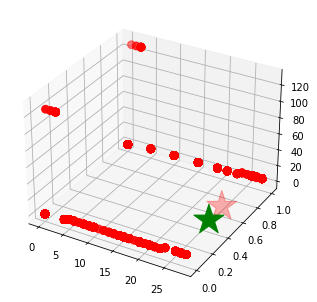

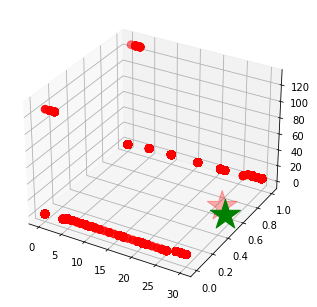

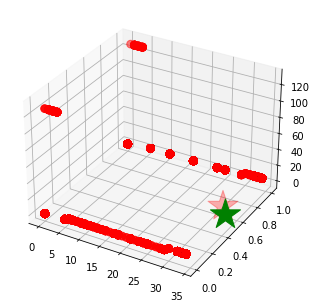

In [38]:
plot_3d(X_no_lan, kmeans.cluster_centers_, labels)
plot_3d(X_no_lan2, kmeans2.cluster_centers_, labels2)
plot_3d(X_no_lan3, kmeans3.cluster_centers_, labels3)

<ipython-input-31-db7fed52555b>:67: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


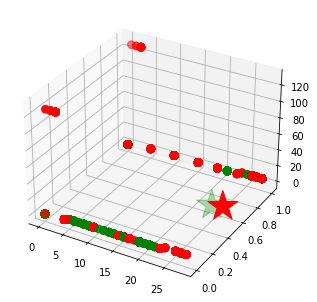

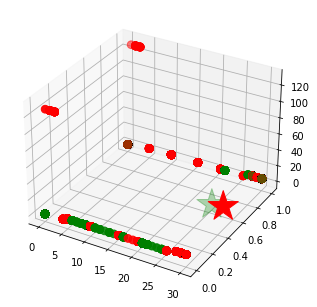

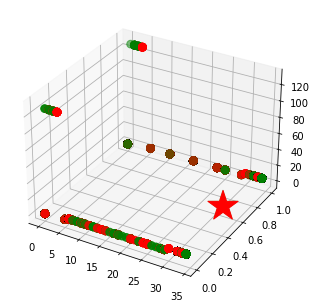

In [39]:
plot_3d(X_no_lan_metadata, kmeans4.cluster_centers_, labels4)
plot_3d(X_no_lan2_metadata, kmeans5.cluster_centers_, labels5)
plot_3d(X_no_lan3_metadata, kmeans6.cluster_centers_, labels6)